# *lsforce* Greenland 16/09/2023

This Python notebook contains the code used to calculate the landslide force history by seismic wave inversion, and is a modified version of the notebook proposed by Allstadt, K. E., Toney, L., & Collins, E. A. (2023) in lsforce (Version 1.1) [Source code]. U.S.
Geological Survey Software Release.
https://doi.org/10.5066/P9CR20KW
https://code.usgs.gov/ghsc/lhp/lsforce

**References**

<p>
<div style="text-indent:-36px; padding-left:36px;">
<p>
Liam Toney, Kate E. Allstadt; lsforce: A Python‐Based Single‐Force Seismic Inversion Framework for Massive Landslides. Seismological Research Letters 2021; 92 (4): 2610–2626. doi: https://doi.org/10.1785/0220210004
</p>
</div>



In [ ]:
!pip install obspy
!pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 26.8 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 24.4 MB/s eta 0:00:00


### Import necessary modules

In [ ]:
from pathlib import Path

from google.colab import drive
drive.mount('/content/gdrive')

from obspy import UTCDateTime, read
from obspy.clients.fdsn import Client
from obspy.geodetics import gps2dist_azimuth
import sys
sys.path.append('/content/gdrive/MyDrive/LandslideInversion/lsforce/lsforce/')
from lsdata import LSData
from lsforce import LSForce
from lstrajectory import LSTrajectory

#, LSForce, LSTrajectory

# Ignore benign Matplotlib backend warning due to fig.show()
import warnings
warnings.filterwarnings(action='ignore', message='Matplotlib is currently using module')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Define some constants, set up folder structure

In [ ]:
PERIOD_RANGE = (10, 60)  #

LS_LAT, LS_LON = (72.813511, -26.961821) # NEW

ORIGIN_TIME = UTCDateTime(2023, 9, 16, 12, 34, 0)

STARTTIME = ORIGIN_TIME - 180  # Get 150 s of extra data prior to estimated start
ENDTIME = UTCDateTime(2023, 9, 16, 12, 40, 0) + 600

# Set up folder structure
main_folder = Path.cwd() / 'Greenland2023'
if not main_folder.exists():
    main_folder.mkdir()

print(main_folder)

/content/Greenland2023


### Gather inversion waveforms


/content/Greenland2023/data.pkl
DK.SCO..BHE -> DK.SCO..BHE
{'azimuth': 90.0, 'dip': 0.0}
Not equal to tolerance rtol=1e-07, atol=0
Mismatched elements: 9 / 22801 (0.0395%)
Max absolute difference: 4.54747351e-13
Max relative difference: 9.37028233e-14
 x: array([732., 728., 725., ..., 373., 374., 377.])
 y: array([732, 728, 725, ..., 373, 374, 377], dtype=int32)

DK.SCO..BHZ -> DK.SCO..BHZ
{'azimuth': 0.0, 'dip': -90.0}
Not equal to tolerance rtol=1e-07, atol=0
Mismatched elements: 4 / 22801 (0.0175%)
Max absolute difference: 3.41060513e-13
Max relative difference: 1.12465592e-13
 x: array([689., 681., 678., ..., 534., 570., 607.])
 y: array([689, 681, 678, ..., 534, 570, 607], dtype=int32)

DK.SCO..HHE -> DK.SCO..HHE
{'azimuth': 90.0, 'dip': 0.0}
Not equal to tolerance rtol=1e-07, atol=0
Mismatched elements: 30 / 114001 (0.0263%)
Max absolute difference: 4.54747351e-13
Max relative difference: 1.28785871e-13
 x: array([728., 733., 731., ..., 372., 374., 378.])
 y: array([728, 733, 731

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://www.ngdc.noaa.gov/mgg/shorelines/data/gshhs/latest/gshhg-shp-2.3.7.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


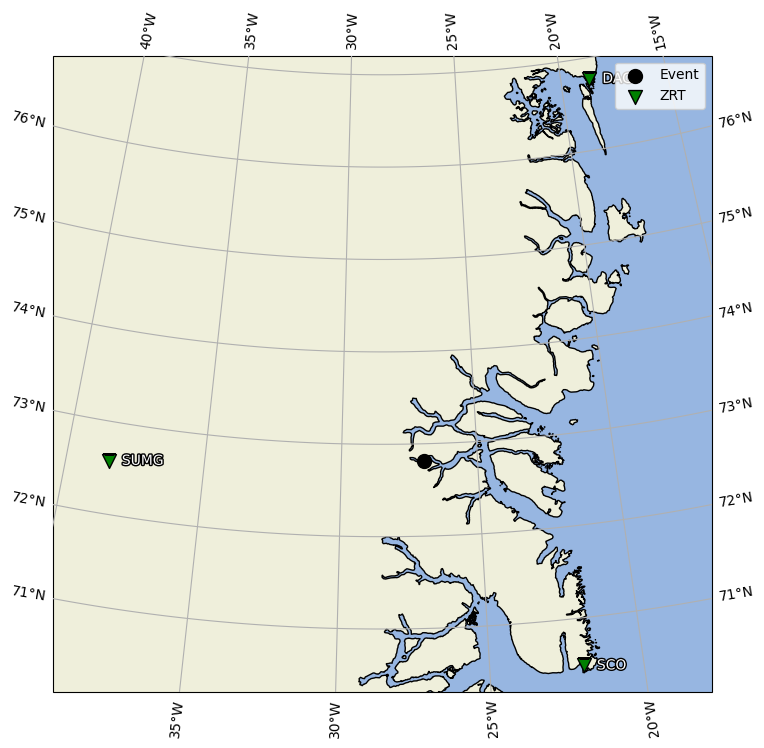

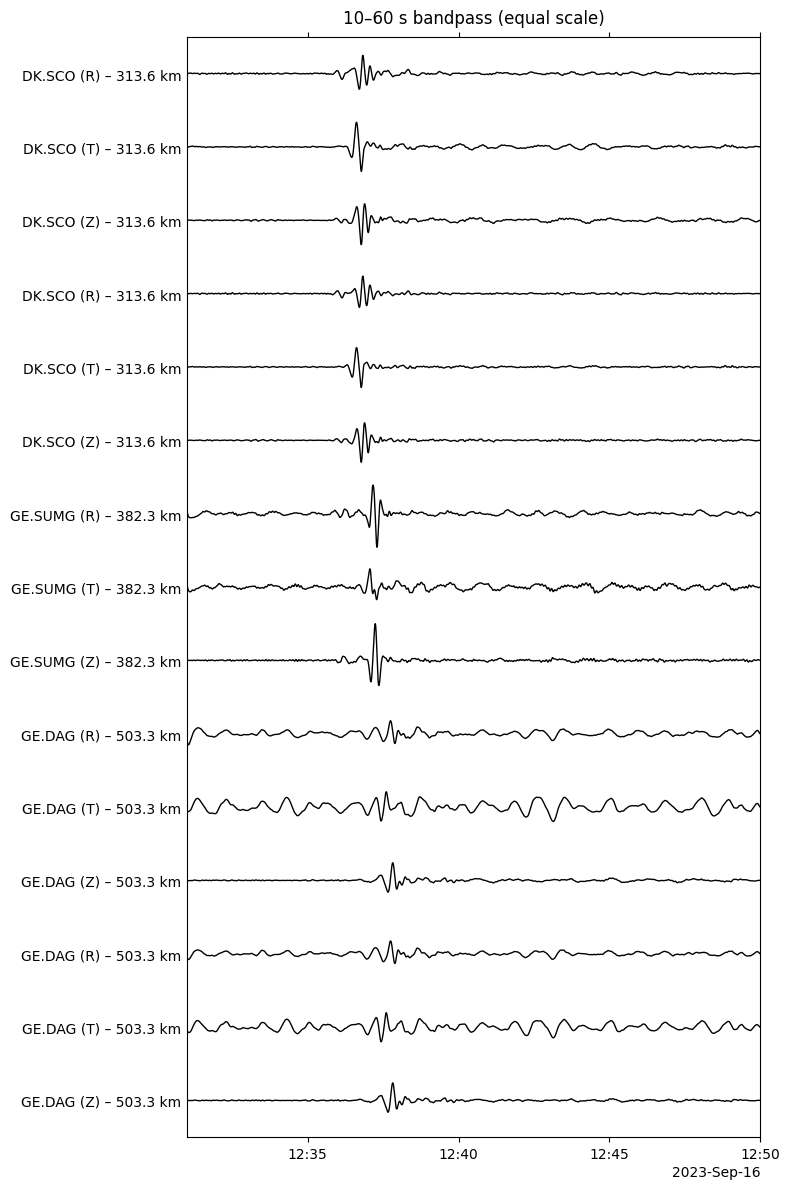

In [ ]:
data_filename = main_folder / 'data.pkl'
print(data_filename)

# Download data if it doesn t exist as a file
if not data_filename.exists():

    client = Client('IRIS')
    waveform_kwargs = dict(
        location='*', starttime=STARTTIME, endtime=ENDTIME, attach_response=True
    )

    # Gather waveforms
    NETWORKS = ('DK', 'GE','II','IU')
    STATIONS = ('SCO','SUMG','DAG','DBG') #STATIONS = ('SCO','SUMG','ILULI','DAG','DBG') BEST??# #STATIONS = ('SCO','SUMG','KARAT','ANGG','BORG','ISOG','ILULI','SFJD')
    network=','.join(NETWORKS)
    st = client.get_waveforms(
        network=','.join(NETWORKS),
        station=','.join(STATIONS),
        channel='BH?,HH?',
        **waveform_kwargs,
    )

    #print(st)

    # Grab coordinates
    inv = client.get_stations(
        network=','.join(NETWORKS),
        starttime=STARTTIME,
        endtime=ENDTIME,
        level='channel',
    )

    #print(inv)

    # Assign coordinates to Traces
    for tr in st:
        coords = inv.get_coordinates(tr.id, datetime=STARTTIME)
        tr.stats.latitude = coords['latitude']
        tr.stats.longitude = coords['longitude']

    st.write(str(data_filename), format='PICKLE')

# Use file if it exists, for speed
else:
    st = read(str(data_filename), format='PICKLE')

# Create LSData object
data = LSData(st, source_lat=LS_LAT, source_lon=LS_LON)

# Create plots
data.plot_stations(label_stations=True, gshhs_scale='h');
data.plot_data(period_range=PERIOD_RANGE, equal_scale=True);

# Remove some noisy horizontals
for station in 'DAG':
  for tr in data.st_proc.select(station=station, component='T'):
      data.st_proc.remove(tr)
# for tr in data.st_proc.select(station='SKAG', component='R'):
#   data.st_proc.remove(tr)

### Gather reference waveform


In [ ]:
SEISMIC_VELO_HF = 3  # [km/s] For travel time removal
SEISMIC_VELO_LP = 3  # [km/s] For travel time removal

KM_PER_M = 1 / 1000  # [km/m]

client = Client('IRIS')

# Gather a single trace
tr_hf = client.get_waveforms(
    network='DK',
    station='SCO',
    location='',
    channel='HHZ',
    starttime=STARTTIME,
    endtime=ENDTIME,
    attach_response=True,
)[0]

# Processing
tr_hf.remove_response()
tr_hf.detrend('demean')
tr_hf.taper(max_percentage=0.05)
tr_hf.filter('bandpass', freqmin=2, freqmax=9.99,zerophase=True)

# Add "distance" to tr.stats
ref_inv = client.get_stations(
    network=tr_hf.stats.network,
    station=tr_hf.stats.station,
    starttime=STARTTIME,
    endtime=ENDTIME,
    level='channel',
)
coords = ref_inv.get_coordinates(tr_hf.id, datetime=STARTTIME)
tr_hf.stats.latitude = coords['latitude']
tr_hf.stats.longitude = coords['longitude']
dist = gps2dist_azimuth(LS_LAT, LS_LON, tr_hf.stats.latitude, tr_hf.stats.longitude)[0]  # [m]
tr_hf.stats.distance = dist * KM_PER_M  # [km]

# Approximate correction for travel time
hf_shift = tr_hf.stats.distance / SEISMIC_VELO_HF

#SAME FOR LP
# Gather a single trace
tr_lp = client.get_waveforms(
    network='DK',
    station='SCO',
    location='',
    channel='BHZ',
    starttime=STARTTIME,
    endtime=ENDTIME,
    attach_response=True,
)[0]

# Processing
tr_lp.remove_response()
tr_lp.detrend('demean')
tr_lp.taper(max_percentage=0.05)
tr_lp.filter('bandpass', freqmin=1/60, freqmax=0.1 , zerophase=True)
#tr_lp.filter('bandpass', freqmin=0.001, freqmax=0.025)

# Add "distance" to tr.stats
ref_inv = client.get_stations(
    network=tr_lp.stats.network,
    station=tr_lp.stats.station,
    starttime=STARTTIME,
    endtime=ENDTIME,
    level='channel',
)
coords = ref_inv.get_coordinates(tr_lp.id, datetime=STARTTIME)
tr_lp.stats.latitude = coords['latitude']
tr_lp.stats.longitude = coords['longitude']
dist = gps2dist_azimuth(LS_LAT, LS_LON, tr_lp.stats.latitude, tr_lp.stats.longitude)[0]  # [m]
tr_lp.stats.distance = dist * KM_PER_M  # [km]

# Approximate correction for travel time
lp_shift = tr_lp.stats.distance / SEISMIC_VELO_LP
print(lp_shift)

#SAME FOR VLP
# Gather a single trace
tr_vlp = client.get_waveforms(
    network='DK',
    station='SCO',
    location='',
    channel='BHZ',
    starttime=STARTTIME,
    endtime=ENDTIME,
    attach_response=True,
)[0]

# Processing
tr_vlp.remove_response()
tr_vlp.detrend('demean')
tr_vlp.taper(max_percentage=0.05)
tr_vlp.filter('bandpass', freqmin=1/200, freqmax=1/40, zerophase=True)

# Add "distance" to tr.stats
ref_inv = client.get_stations(
    network=tr_vlp.stats.network,
    station=tr_vlp.stats.station,
    starttime=STARTTIME,
    endtime=ENDTIME,
    level='channel',
)
coords = ref_inv.get_coordinates(tr_vlp.id, datetime=STARTTIME)
tr_vlp.stats.latitude = coords['latitude']
tr_vlp.stats.longitude = coords['longitude']
dist = gps2dist_azimuth(LS_LAT, LS_LON, tr_vlp.stats.latitude, tr_vlp.stats.longitude)[0]  # [m]
tr_vlp.stats.distance = dist * KM_PER_M  # [km]

# Approximate correction for travel time
vlp_shift = tr_lp.stats.distance / SEISMIC_VELO_LP
print(vlp_shift)

104.54963558923406
104.54963558923406


### Setup triangle parameterization methods

In [ ]:
INIT_KWARGS = dict(data=data, data_sampling_rate=1, main_folder=main_folder)

force_triangle = LSForce(method='triangle', **INIT_KWARGS)

SETUP_KWARGSTRI = dict(
    period_range=PERIOD_RANGE,


    syngine_model='iasp91_2s',
    triangle_half_width=2, #best ? = 7s
    skip_datafilter=False,
    weights='distance'
)

force_triangle.setup(**SETUP_KWARGSTRI)

Getting Green's functions...
Downloaded DAG (1/3)
Downloaded SCO (2/3)
Downloaded SUMG (3/3)


### Invert

In [ ]:
INVERT_KWARGS = dict(
    zero_time=200,
    impose_zero_start=True,
    duration=90,
    add_to_zero=True,
    jackknife=True,
    num_iter=30,
    frac_delete=0.25,
    zero_scaler=5,
)

force_triangle.invert(tikhonov_ratios=(0, 0, 1), alpha=4.0e-18, **INVERT_KWARGS)

Variance reduction = 41.039251 percent
Starting jackknife iterations
Jackknife VR stats: max 55, min 34, median 40


### Plot inversion results


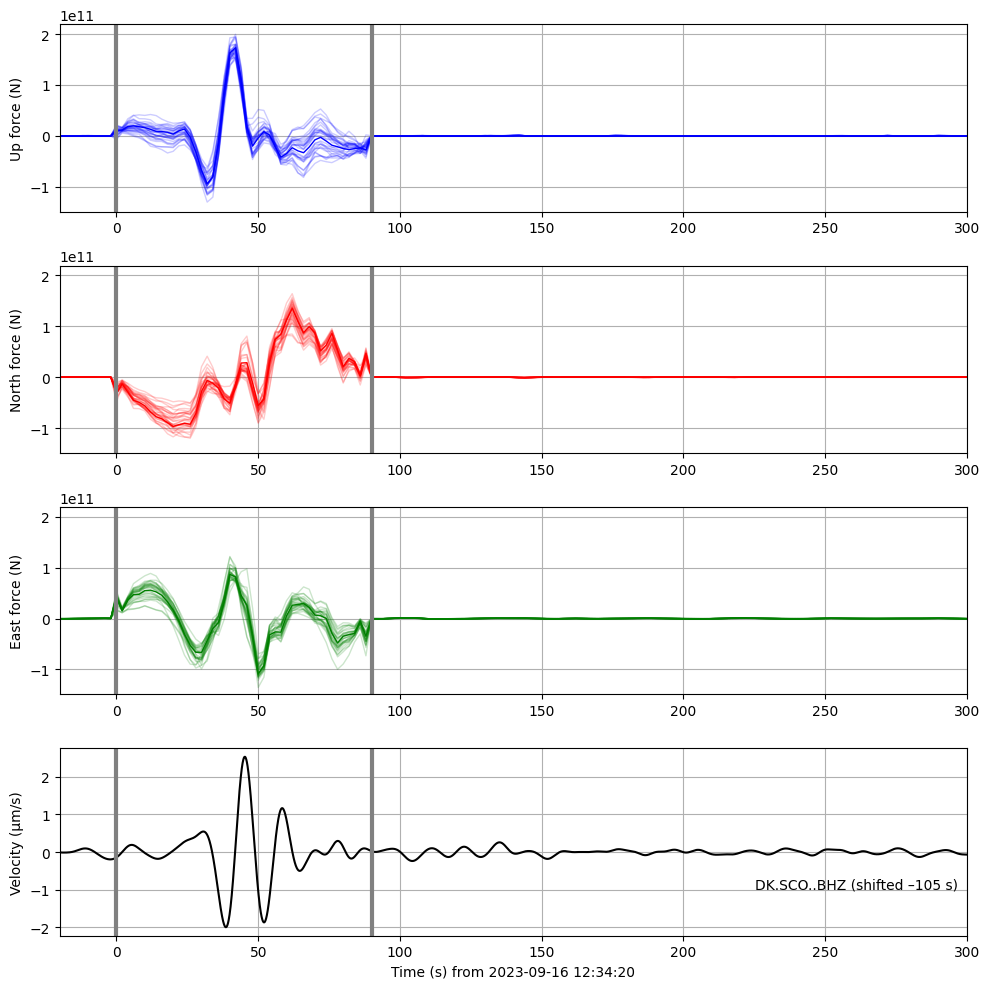

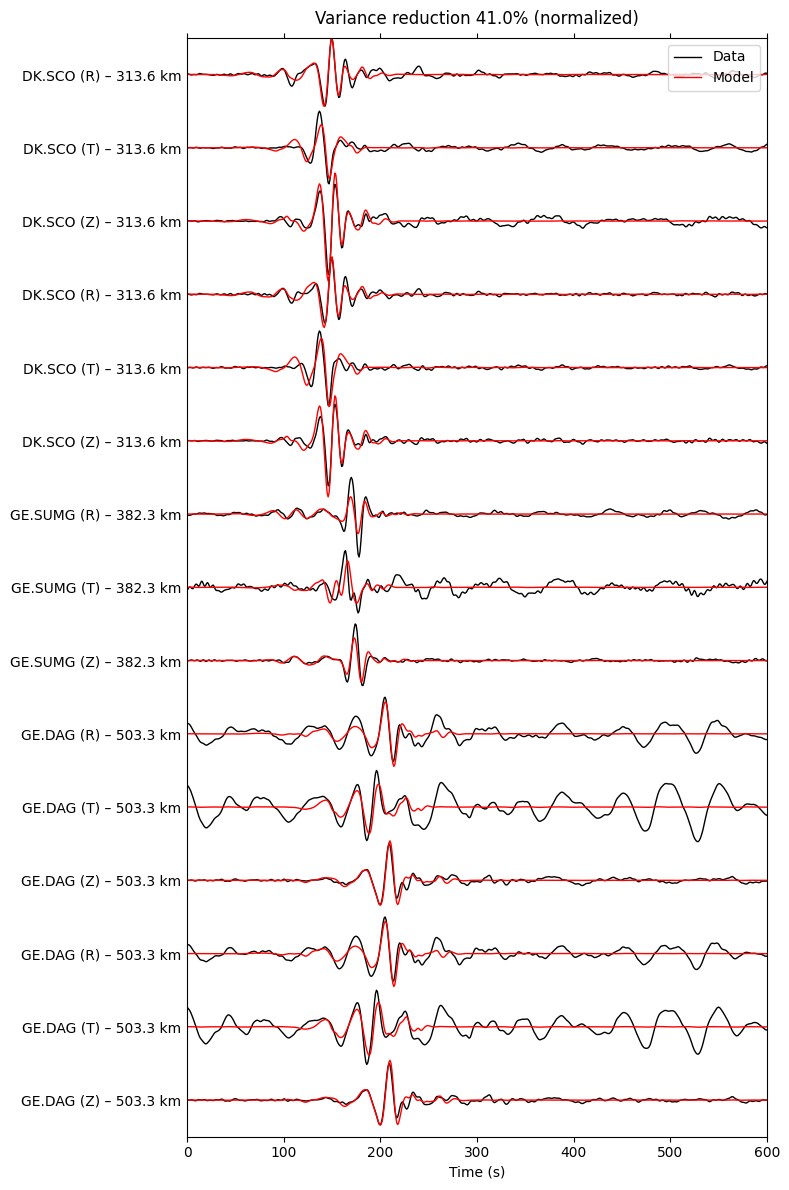

In [ ]:
XLIM = (-20, 300)  # [s] x-axis (time) limits for plots
force_triangle.plot_forces(highf_tr=tr_lp, hfshift=lp_shift, jackshowall=True, xlim=XLIM);
force_triangle.plot_fits(xlim=(0, 600), equal_scale=False);

### Compute trajectories


In [ ]:
L = 2.2  # [km] Estimate of horizontal COM runout length

DURATION = 110 # [s] Duration to use for trajectory integration Best=80
ZERO_ACC = 110 # [s] Duration after which accelerations are set to zero

TRAJECTORY_KWARGS = dict(target_length=L, duration=DURATION, detrend_velocity=DURATION, mass=None, zeroacc=ZERO_ACC)

trajectory_triangle = LSTrajectory(force_triangle, **TRAJECTORY_KWARGS)

### Plot trajectories


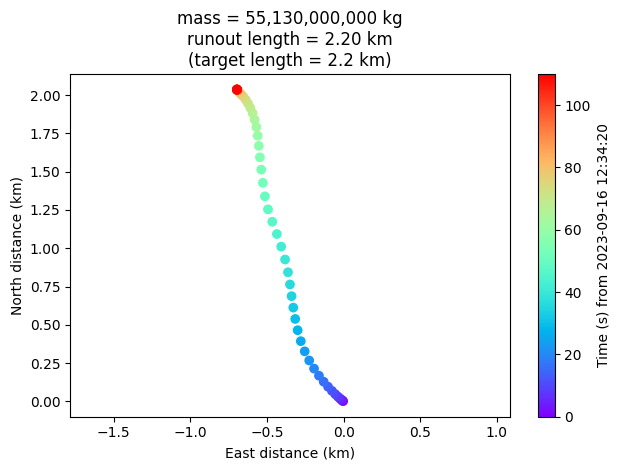

In [ ]:
# Plot trajectories for the triangle inversion
trajectory_triangle.plot_trajectory(plot_jackknife=False);  # Horizontal trajectory
# trajectory_triangle.plot_trajectory(plot_jackknife=True, elevation_profile=True);  # Vertical trajectory

VZt=trajectory_triangle.velocity['Z']
VEt=trajectory_triangle.velocity['E']
VNt=trajectory_triangle.velocity['N']

AZt=trajectory_triangle.acceleration['Z']
AEt=trajectory_triangle.acceleration['E']
ANt=trajectory_triangle.acceleration['N']

In [ ]:
### GET COORDINATES OF TRAJ IN EPSG :
import pyproj

# Define the projection systems
wgs84 = pyproj.Proj(proj='latlong', datum='WGS84')
utm = pyproj.Proj(proj='utm', zone=43, datum='WGS84')  # UTM zone 33 for example

# Coordinates in EPSG:4326 (latitude, longitude) O point
longitude, latitude = 72.812255, -26.952289

# Convert coordinates from EPSG:4326 to UTM
utm_x, utm_y = pyproj.transform(wgs84, utm, longitude, latitude)

print("UTM Coordinates (X, Y):", utm_x, utm_y)

trajectory_triangle.displacement
DN=trajectory_triangle.displacement['N']+utm_y
DE=trajectory_triangle.displacement['E']+utm_x
longitudeLand, latitudeLand = pyproj.transform(utm, wgs84, DE, DN)

UTM Coordinates (X, Y): 282819.62645744934 -2983030.747334759


<ipython-input-10-3736507f50ae>:12: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  utm_x, utm_y = pyproj.transform(wgs84, utm, longitude, latitude)
<ipython-input-10-3736507f50ae>:19: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  longitudeLand, latitudeLand = pyproj.transform(utm, wgs84, DE, DN)


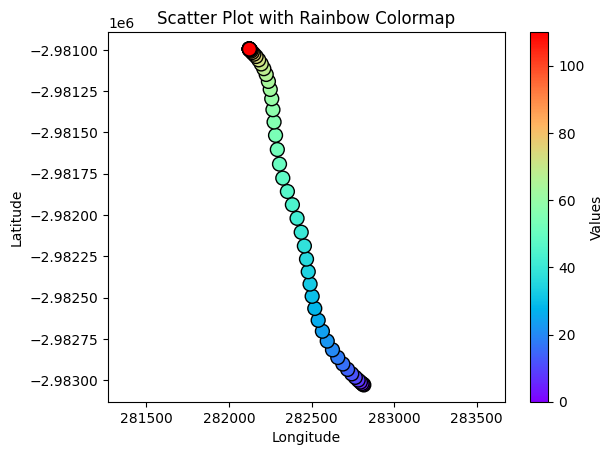

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np

# Sample latitude and longitude data
latitude = DE
longitude = DN

# Sample values corresponding to each coordinate
values = trajectory_triangle.traj_tvec

# Combine latitude, longitude, and values into a list of tuples
data = list(zip(longitude, latitude, values))

# Create a GeoDataFrame with Point geometries and values
geometry = [Point(lon, lat) for lat, lon, _ in data]
gdf = gpd.GeoDataFrame(geometry=geometry, columns=['geometry'])
gdf['values'] = values

# Plot the scatter plot with rainbow colormap
fig, ax = plt.subplots()
scatter = ax.scatter([lon for _, lon, _ in data], [lat for lat, _, _ in data], c=values, cmap='rainbow', s=100, edgecolor='k')
plt.colorbar(scatter, ax=ax, label='Values')  # Add colorbar with value labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Scatter Plot with Rainbow Colormap')
ax.axis('equal')
plt.show()

# Save the GeoDataFrame as a shapefile
gdf.to_file('scatter_plot.shp')


In [ ]:
print(data)

[(-2983028.438321168, 282816.657295088, 0.0), (-2983025.1664750427, 282812.5953501357, 2.0), (-2983019.8032109844, 282805.94611027394, 4.0), (-2983011.151707094, 282795.9141758048, 6.0), (-2982998.923154199, 282782.44649098866, 8.0), (-2982982.6227104696, 282765.022809666, 10.0), (-2982961.3755423273, 282743.5792038665, 12.0), (-2982934.498249167, 282718.3644839804, 14.0), (-2982901.6999964127, 282689.860763452, 16.0), (-2982862.415078806, 282659.00207215897, 18.0), (-2982816.1112784008, 282626.9548611517, 20.0), (-2982763.033903531, 282595.2898323537, 22.0), (-2982703.3882469255, 282565.9196780568, 24.0), (-2982637.04021002, 282540.40831001394, 26.0), (-2982565.5093967877, 282519.75127257, 28.0), (-2982491.96914089, 282503.96918121004, 30.0), (-2982417.9836903135, 282491.3845334176, 32.0), (-2982343.1502213352, 282480.25741943216, 34.0), (-2982266.7589835958, 282469.72478060675, 36.0), (-2982187.29167316, 282456.831899385, 38.0), (-2982104.103385408, 282437.6659861667, 40.0), (-298201

In [ ]:
MAXFORCE=np.max(np.sqrt(force_triangle.E**2+force_triangle.N**2+force_triangle.Z**2))
MEKST=MAXFORCE*0.54
MCHAO=MAXFORCE*0.405
print(np.max(np.sqrt(force_triangle.E**2+force_triangle.N**2+force_triangle.Z**2)))
print(MEKST)
print(MCHAO)

192108867393.8902
103738788392.70071
77804091294.52553


In [ ]:
FULLACC=np.sqrt(AZt**2+AEt**2+ANt**2)
print(np.max(FULLACC))
print(trajectory_triangle.traj_tvec[np.argmax(FULLACC)])

FULLVEL=np.sqrt(VZt**2+VEt**2+VNt**2)
print(np.max(FULLVEL))
print(trajectory_triangle.traj_tvec[np.argmax(FULLVEL)])


3.4846520477759877
42.0
46.80952269377098
52.0


In [ ]:
## FINAL PLOT
import pandas as pd

FileFsim=pd.read_csv('/content/force_inv_sumul_10_60s.csv',sep=',')
print(FileFsim)
FSIM=FileFsim.values

highf_tr=tr_hf
tvec = np.linspace(0,(len(highf_tr.data) - 1) * 1 / highf_tr.stats.sampling_rate, num=len(highf_tr.data))
tvec -= hf_shift
tvec -= force_triangle.zero_time

tvec2 = np.linspace(0,(len(tr_lp.data) - 1) * 1 / tr_lp.stats.sampling_rate,num=len(tr_lp.data))
tvec2 -= lp_shift
tvec2 -= force_triangle.zero_time

fig=plt.figure(figsize=(14,12))
FSZ=10
ax1 = fig.add_subplot(411)
# plt.plot(tvec2,tr_hf.data,'k')
# plt.plot(tvec2,tr_lp.data,'r')
plt.xlim((-20,300))
plt.grid()
plt.ylabel('Ground Velocity [m/s]',fontsize=FSZ)

######################################################################### S1
color = [0.0, 0.1, 0.3]
#ax1.set_xlabel('time (s)')
ax1.set_ylabel('HF and VLP Ground Velocity [m/s]', fontsize=FSZ)
aa1=ax1.plot(tvec, tr_hf.data, color=color, label='DK.SCO.BHZ HF | 2-10 Hz')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(-7*10**-7,7*10**-7)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
colorLP = [0.9, 0.4, 0.1]
colorVLP = [0.0, 0.7, 0.8]
ax2.set_ylabel('LP Ground Velocity [m/s]', color=colorLP,fontsize=FSZ)  # we already handled the x-label with ax1
aa2=ax2.plot(tvec2, tr_lp.data, color=colorLP, linewidth=2, label='DK.SCO.BHZ LP | 10 - 60s')
aa3=ax1.plot(tvec2, tr_vlp.data, color=colorVLP, linewidth=2, label='DK.SCO.BHZ VLP | 40 - 200s')
ax2.tick_params(axis='y', labelcolor=colorLP)
ax2.set_ylim(-3.0*10**-6,3.0*10**-6)
#"ax2.set_ylim(-1*10**-6,1*10**-6)

lns = aa1+aa2+aa3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=1)
 ######################################################################### S2
ax412 = plt.subplot(412)
plt.grid()
#plt.scatter(trajectory_triangle.traj_tvec,-(1.25*10**11)*np.ones(len(trajectory_triangle.traj_tvec)),c=range(len(trajectory_triangle.traj_tvec)),cmap='rainbow')
plt.plot(force_triangle.tvec, -force_triangle.Z, 'b', linewidth=2,label='Vertical')
plt.plot(force_triangle.tvec, -force_triangle.N, 'r', linewidth=2,label='North')
plt.plot(force_triangle.tvec, -force_triangle.E, 'g', linewidth=2,label='East')

plt.ylabel('Inverted Forces [N]',fontsize=FSZ)
plt.xlim((-20,300))
plt.ylim((-1.75*10**11,1.25*10**11))
ax412.legend(loc=1)


# plt.subplot(413)
# plt.plot(trajectory_triangle.traj_tvec,np.sqrt(AZt**2+AEt**2+ANt**2))
# plt.xlim((-20,250))
# plt.grid()
# plt.ylabel('Acceleration [m/s^2]')

######################################################################### S3
ax4 = fig.add_subplot(413)
plt.grid()
#plt.scatter(trajectory_triangle.traj_tvec,-(1.25*10**11)*np.ones(len(trajectory_triangle.traj_tvec)),c=range(len(trajectory_triangle.traj_tvec)),cmap='rainbow')
plt.plot(FSIM[:,1], FSIM[:,2], 'b', linewidth=2,label='Vertical')
plt.plot(FSIM[:,1], FSIM[:,3], 'r', linewidth=2,label='North')
plt.plot(FSIM[:,1], FSIM[:,4], 'g', linewidth=2,label='East')

plt.ylabel('Simulated Forces [N]',fontsize=FSZ)
plt.xlim((-20,300))
plt.ylim((-1.3*10**11,1.3*10**11))
ax4.legend(loc=1)

######################################################################### S4
ax1 = fig.add_subplot(414)

AA=np.max([AZt,AEt,ANt])
VV=np.max([VZt,VEt,VNt])
VV=np.max(np.sqrt(VZt**2+VEt**2+VNt**2))
print(AA)
NormAV=VZt*AZt/AA+ANt/AA*VNt+VEt*AEt/AA
NormVA=AZt*VZt/VV+VNt/VV*ANt+AEt*VEt/VV

plt.xlim((-20,300))
plt.grid()
plt.ylabel('Ground Velocity [m/s]',fontsize=FSZ)

color = [0.0, 0.1, 0.3]
#ax1.set_xlabel('time (s)')
ax1.set_ylabel('Inverted Acceleration [$m/s^2$]', fontsize=FSZ)
aa1=ax1.plot(trajectory_triangle.traj_tvec,np.sqrt(AZt**2+AEt**2+ANt**2),linewidth=2,label='A')
aa2=ax1.plot(trajectory_triangle.traj_tvec,NormVA,label='A o V̂')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(-2,4)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
colorLP = [0.9, 0.4, 0.1]
colorVLP = [0.0, 0.7, 0.8]
ax2.set_ylabel('Inverted Velocity [m/s]',color='r',fontsize=FSZ)  # we already handled the x-label with ax1
ax1.set_xlabel('Time [s] from 2023-09-16 12:34:20 (UTC)',fontsize=FSZ)  # we already handled the x-label with ax1
aa3=ax2.plot(trajectory_triangle.traj_tvec,np.sqrt(VZt**2+VEt**2+VNt**2),linewidth=2, color='r', label='V')
aa4=ax1.scatter(trajectory_triangle.traj_tvec,-2*np.ones(len(trajectory_triangle.traj_tvec)),c=range(len(trajectory_triangle.traj_tvec)),cmap='rainbow')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(-27,50)
#"ax2.set_ylim(-1.1*10**-6,1.1*10**-6)

lns = aa1+aa2+aa3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=1)

plt.savefig('finalfig3.pdf')

print(len(trajectory_triangle.traj_tvec))

FileNotFoundError: ignored